In [1]:
import json
import math
import random
import os
import pickle as pkl
import time
from typing import Dict, List

import awkward as ak
import fastjet
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import sklearn
import sklearn.metrics
import torch
import tqdm
import vector
from torch_geometric.data import Batch, Data

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import relevant functions from mlpf.pyg
import sys
sys.path.append("/home/jovyan/particleflow/mlpf/")
import pyg
sys.path.append("/home/jovyan/particleflow/mlpf/pyg/")
import utils

from PFDataset import PFDataset, PFDataLoader, Collater

from pyg.mlpf import MLPF
from pyg.utils import X_FEATURES, Y_FEATURES, unpack_predictions
from jet_utils import match_two_jet_collections

#################################### must update this function to have the proper p4
def unpack_target(y):
    ret = {}
    ret["cls_id"] = y[..., 0].long()
    ret["charge"] = torch.clamp((y[..., 1] + 1).to(dtype=torch.float32), 0, 2)  # -1, 0, 1 -> 0, 1, 2

    for i, feat in enumerate(Y_FEATURES):
        if i >= 2:  # skip the cls and charge as they are defined above
            ret[feat] = y[..., i].to(dtype=torch.float32)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])

    # do some sanity checks
    # assert torch.all(ret["pt"] >= 0.0)  # pt
    # assert torch.all(torch.abs(ret["sin_phi"]) <= 1.0)  # sin_phi
    # assert torch.all(torch.abs(ret["cos_phi"]) <= 1.0)  # cos_phi
    # assert torch.all(ret["energy"] >= 0.0)  # energy

    # note ~ momentum = ["pt", "eta", "sin_phi", "cos_phi", "energy"]
    ret["momentum"] = y[..., 2:7].to(dtype=torch.float32)
    ret["p4"] = torch.cat(
        [ret["pt"].unsqueeze(-1), ret["eta"].unsqueeze(-1), ret["phi"].unsqueeze(-1), ret["energy"].unsqueeze(-1)], axis=-1
    )

    ret["genjet_idx"] = y[..., -1].long()

    return ret

In [4]:
# define the global base device
world_size = 1
if torch.cuda.device_count():
    rank = 0
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    rank = "cpu"
    device = "cpu"
    print("Will use cpu")

Will use NVIDIA A100-SXM4-80GB


# Load the pre-trained MLPF model

In [5]:
def load_checkpoint(checkpoint, model, optimizer=None):
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model.module.load_state_dict(checkpoint["model_state_dict"])
    else:
        model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        return model, optimizer
    else:
        return model
    
    
loaddir = "/pfvol/experiments/MLPF_clic_A100_1gpu_pyg-clic_20240322_233518_004447"

with open(f"{loaddir}/model_kwargs.pkl", "rb") as f:
    mlpf_kwargs = pkl.load(f)

mlpf_kwargs["attention_type"] = "flash"

mlpf = MLPF(**mlpf_kwargs).to(torch.device(rank))
checkpoint = torch.load(f"{loaddir}/best_weights.pth", map_location=torch.device(rank))

mlpf = load_checkpoint(checkpoint, mlpf)
mlpf.eval()

print(mlpf)    

MLPF(
  (nn0): Sequential(
    (0): Linear(in_features=17, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv_id): ModuleList(
    (0-2): 3 x SelfAttentionLayer(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (seq): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ELU(alpha=1.0)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (conv_reg): ModuleList(
    (0-2): 3 x SelfAttentionLayer(
      (mha): MultiheadAttention(
        (ou

# CLIC dataset

In [6]:
! ls /pfvol/tensorflow_datasets/

clic_edm_qq_pf		   cms_pf_qcd_high_pt	   cms_pf_single_proton
clic_edm_ttbar_pf	   cms_pf_single_electron  cms_pf_single_tau
clic_edm_ttbar_pu10_pf	   cms_pf_single_gamma	   cms_pf_sms_t1tttt
clic_edm_ww_fullhad_pf	   cms_pf_single_mu	   cms_pf_ttbar
clic_edm_zh_tautau_pf	   cms_pf_single_neutron   cms_pf_ztt
cms_pf_multi_particle_gun  cms_pf_single_pi	   delphes_qcd_pf
cms_pf_qcd		   cms_pf_single_pi0	   delphes_ttbar_pf


In [7]:
# we can see the 17th features here (recall type is 1 for tracks and 2 for clusters)
X_FEATURES["clic"]

['type',
 'pt | et',
 'eta',
 'sin_phi',
 'cos_phi',
 'p | energy',
 'chi2 | position.x',
 'ndf | position.y',
 'dEdx | position.z',
 'dEdxError | iTheta',
 'radiusOfInnermostHit | energy_ecal',
 'tanLambda | energy_hcal',
 'D0 | energy_other',
 'omega | num_hits',
 'Z0 | sigma_x',
 'time | sigma_y',
 'Null | sigma_z']

In [8]:
# we can see the 8 gen features per pf element here (notice the jet_index which may be useful)
Y_FEATURES

['cls_id', 'charge', 'pt', 'eta', 'sin_phi', 'cos_phi', 'energy']

# Get the dataset (Events)

In [9]:
data_dir = "/home/jovyan/particleflow/tensorflow_datasets/"
sample = "clic_edm_ttbar_pf"

dataset_train = PFDataset(data_dir, f"{sample}:1.5.0", "train", num_samples=10_000)

batch_size = 100
pad_3d = True
train_loader = PFDataLoader(dataset_train.ds,
                               batch_size=batch_size,
                               collate_fn=Collater(["X", "ygen", "ycand"], pad_3d=pad_3d),
                              )

In [10]:
for batch in train_loader:
    batch = batch.to(rank, non_blocking=True)
    break
print(batch.X.shape)    

torch.Size([100, 246, 17])


# Pre-processing (Events -> Jets)

In [11]:
############################### set up forward hooks to retrive the latent representations of MLPF
latent_reps = {}
def get_activations(name):
    def hook(mlpf, input, output):
        latent_reps[name] = output.detach()

    return hook

mlpf.conv_reg[0].dropout.register_forward_hook(get_activations("conv_reg0"))
mlpf.conv_reg[1].dropout.register_forward_hook(get_activations("conv_reg1"))
mlpf.conv_reg[2].dropout.register_forward_hook(get_activations("conv_reg2"))
mlpf.nn_id.register_forward_hook(get_activations("nn_id"))    
###############################

def get_latent_reps(batch, latent_reps):
    for layer in latent_reps:
        if "conv" in layer:
            latent_reps[layer] *= batch.mask.unsqueeze(-1)

    latentX = torch.cat(
        [
            batch.X.to(rank),
            latent_reps["conv_reg0"],
            latent_reps["conv_reg1"],
            latent_reps["conv_reg2"],
            latent_reps["nn_id"],
        ],
        axis=-1,
    )
    return latentX

In [12]:
sample_to_lab = {
    "clic_edm_ttbar_pf": 1,
    "clic_edm_qq_pf": 0,   
}

####################### Config
jetdef = fastjet.JetDefinition(fastjet.ee_genkt_algorithm, 0.7, -1.0)
jet_ptcut = 15.0
jet_match_dr = 0.1

save_every_X_batch = 3       # will save to disk every "X" batches

######################## Build the dataset
jet_dataset = []    # will save on disk and reinitialize at the end of the loop
saving_i = 0        # will just increment with every save

for ibatch, batch in enumerate(train_loader):

    # run the MLPF model in inference mode to get the MLPF cands / latent representations  
    print(f"Running MLPF inference on batch {ibatch}")
    batch = batch.to(rank, non_blocking=True)
    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=True):
            ymlpf = mlpf(batch.X, batch.mask)
    ymlpf = unpack_predictions(ymlpf)
    
    # get the latent representations
    ymlpf["latentX"] = get_latent_reps(batch, latent_reps)

    for k, v in ymlpf.items():
        ymlpf[k] = v.detach().cpu()
    
    jets_coll = {}
    ####################### get the reco jet collection
    vec = vector.awk(
        ak.zip(
            {
                "pt": ymlpf["p4"][:, :, 0].to("cpu"),
                "eta": ymlpf["p4"][:, :, 1].to("cpu"),
                "phi": ymlpf["p4"][:, :, 2].to("cpu"),
                "e": ymlpf["p4"][:, :, 3].to("cpu"),
            }
        )
    )
    cluster = fastjet.ClusterSequence(vec.to_xyzt(), jetdef)
    jets_coll["reco"] = cluster.inclusive_jets(min_pt=jet_ptcut)
    
    # get the constituents to mask the MLPF candidates and build the input for the downstream    
    reco_constituents = cluster.constituent_index(min_pt=jet_ptcut)
    #######################    
    
    ####################### get the gen jet collection
    ygen = unpack_target(batch.ygen)    
    vec = vector.awk(
        ak.zip(
            {
                "pt": ygen["p4"][:, :, 0].to("cpu"),
                "eta": ygen["p4"][:, :, 1].to("cpu"),
                "phi": ygen["p4"][:, :, 2].to("cpu"),
                "e": ygen["p4"][:, :, 3].to("cpu"),
            }
        )
    )
    cluster = fastjet.ClusterSequence(vec.to_xyzt(), jetdef)
    jets_coll["gen"] = cluster.inclusive_jets(min_pt=jet_ptcut)           
    #######################
    
    matched_jets = match_two_jet_collections(jets_coll, "reco", "gen", jet_match_dr)
    
    # build the big jet list
    for iev in tqdm.tqdm(range(len(matched_jets["gen"]))):
        
        num_matched_jets = len(matched_jets["gen"][iev])   # number of gen jets matched to reco
        
        jets_per_event = []
        for j in range(num_matched_jets):
            
            # get the actual indices of the matched jets
            igenjet = matched_jets["gen"][iev][j]
            irecojet = matched_jets["reco"][iev][j]

            # build a mask tensor that will select the particles that belong to the gen jet            
            msk_indices = reco_constituents[iev][irecojet].to_numpy()

            if len(msk_indices)<3:
                # don't save jets with very few particles
                continue

            jets_per_event += [

                Data(
                    # Target for jet tagging
                    gen_jet_label=torch.tensor(sample_to_lab[sample]).unsqueeze(0).to(dtype=torch.float32),

                    # Target for jet p4 regression                    
                    gen_jet_pt=torch.tensor(jets_coll["gen"][iev][igenjet].pt, dtype=torch.float32).unsqueeze(0),
                    gen_jet_eta=torch.tensor(jets_coll["gen"][iev][igenjet].eta, dtype=torch.float32).unsqueeze(0),
                    gen_jet_phi=torch.tensor(jets_coll["gen"][iev][igenjet].phi, dtype=torch.float32).unsqueeze(0),
                    gen_jet_energy=torch.tensor(jets_coll["gen"][iev][igenjet].energy, dtype=torch.float32).unsqueeze(0),
                    
                    # could be part of the target
                    reco_jet_pt=torch.tensor(jets_coll["reco"][iev][irecojet].pt, dtype=torch.float32).unsqueeze(0),
                    reco_jet_eta=torch.tensor(jets_coll["reco"][iev][irecojet].eta, dtype=torch.float32).unsqueeze(0),
                    reco_jet_phi=torch.tensor(jets_coll["reco"][iev][irecojet].phi, dtype=torch.float32).unsqueeze(0),
                    reco_jet_energy=torch.tensor(jets_coll["reco"][iev][irecojet].energy, dtype=torch.float32).unsqueeze(0),
                    
                    # Input
                    mlpfcands_momentum=ymlpf["momentum"][iev][msk_indices],
                    mlpfcands_pid=ymlpf["cls_id_onehot"][iev][msk_indices],
                    mlpfcands_charge=ymlpf["charge"][iev][msk_indices],
                    mlpfcands_latentX=ymlpf["latentX"][iev][msk_indices],
                )
            ]

#             break  # per jet            
        
        random.shuffle(jets_per_event)
        jet_dataset += jets_per_event

#         break   # per event

    random.shuffle(jet_dataset)
    if (ibatch % (save_every_X_batch-1) == 0) and (ibatch != 0):
        print(f"saving at iteration {ibatch} on disk /pfvol/jetdataset/{sample}/train/{saving_i}.pt")
        torch.save(jet_dataset, f"/pfvol/jetdataset/{sample}/train/{saving_i}.pt")
        saving_i += 1
        jet_dataset = []
        break    # per batch

Running MLPF inference on batch 0
#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.94it/s]


Running MLPF inference on batch 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


Running MLPF inference on batch 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01it/s]


saving at iteration 2 on disk /pfvol/jetdataset/clic_edm_ttbar_pf/train/0.pt


# Load the dataset

In [16]:
! du -sh /pfvol/jetdataset/clic_edm_ttbar_pf/train/0.pt

97M	/pfvol/jetdataset/clic_edm_ttbar_pf/train/0.pt


In [17]:
# load one of the train files
jet_dataset = torch.load("/pfvol/jetdataset/clic_edm_ttbar_pf/train/0.pt")

In [18]:
len(jet_dataset)

1095

In [19]:
# inspect one jet
ijet = 0

print(f"Jet # {ijet}")
print(f"keys {jet_dataset[iev].keys()}")
print("--------------------------")
print("    gen jet pt:", jet_dataset[ijet]["gen_jet_pt"].item())
print("    reco jet pt:"# Load the dataset, jet_dataset[ijet]["reco_jet_pt"].item())
print("--------------------------")
print("    mlpfcands_momentum:", jet_dataset[0]["mlpfcands_momentum"].shape, "- 19 particles with 5 p4 features (pt, eta, sphi, cphi, energy)")
print("    mlpfcands_pid:", jet_dataset[0]["mlpfcands_pid"].shape, "- 19 particles with 6 PID features")
print("    mlpfcands_charge:", jet_dataset[0]["mlpfcands_charge"].shape, "- 19 particles with 3 charge features")
print("    mlpfcands_latentX:", jet_dataset[0]["mlpfcands_latentX"].shape, "- 19 particles with 791 latent features")

Jet # 0
keys ['gen_jet_eta', 'reco_jet_pt', 'mlpfcands_pid', 'gen_jet_phi', 'gen_jet_energy', 'reco_jet_energy', 'gen_jet_label', 'reco_jet_eta', 'reco_jet_phi', 'gen_jet_pt', 'mlpfcands_charge', 'mlpfcands_momentum', 'mlpfcands_latentX']
--------------------------
    gen jet pt: 38.71002960205078
    reco jet pt: 36.20844268798828
--------------------------
    mlpfcands_momentum: torch.Size([26, 5]) - 19 particles with 5 p4 features (pt, eta, sphi, cphi, energy)
    mlpfcands_pid: torch.Size([26, 6]) - 19 particles with 6 PID features
    mlpfcands_charge: torch.Size([26, 3]) - 19 particles with 3 charge features
    mlpfcands_latentX: torch.Size([26, 791]) - 19 particles with 791 latent features


# Build a DataLoader

In [21]:
# Define your custom collate function to add a batch key
def collate_fn(data_list):
    batch = Batch.from_data_list(data_list)
    
    batch_list = []
    for ijet, jet in enumerate(data_list):
        num_MLPFcands = len(jet["mlpfcands_momentum"])   # number of MLPFcands
        batch_list += [ijet] * num_MLPFcands

    batch.batch = torch.tensor(batch_list)
    
    return batch

In [22]:
jetloader = torch.utils.data.DataLoader(jet_dataset, batch_size=5, collate_fn=collate_fn)

In [23]:
for batch in jetloader:
    break
batch.keys()    

['gen_jet_eta',
 'reco_jet_pt',
 'mlpfcands_pid',
 'gen_jet_phi',
 'gen_jet_energy',
 'batch',
 'reco_jet_energy',
 'gen_jet_label',
 'reco_jet_eta',
 'reco_jet_phi',
 'gen_jet_pt',
 'mlpfcands_charge',
 'mlpfcands_momentum',
 'mlpfcands_latentX']

In [24]:
batch["gen_jet_pt"]

tensor([38.7100, 16.4567, 31.4733, 45.9380, 66.5003])

In [25]:
batch["reco_jet_pt"]

tensor([36.2084, 15.6482, 41.6876, 48.7271, 80.7797])

In [26]:
batch["mlpfcands_momentum"].shape   # 237 particles per jet; 5 p4 info (pt, eta, sphi, cphi, e)

torch.Size([154, 5])

In [27]:
batch["batch"]   # indices to which jet the particles belong

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

# Quick validation

In [28]:
genjets, recojets = {}, {}
for x in ["pt", "eta", "phi", "energy"]:
    genjets[x], recojets[x] = [], []
        
for batch in jetloader:
    
    for x in ["pt", "eta", "phi", "energy"]:
        genjets[x] += batch[f"gen_jet_{x}"].tolist()
        recojets[x] += batch[f"reco_jet_{x}"].tolist()

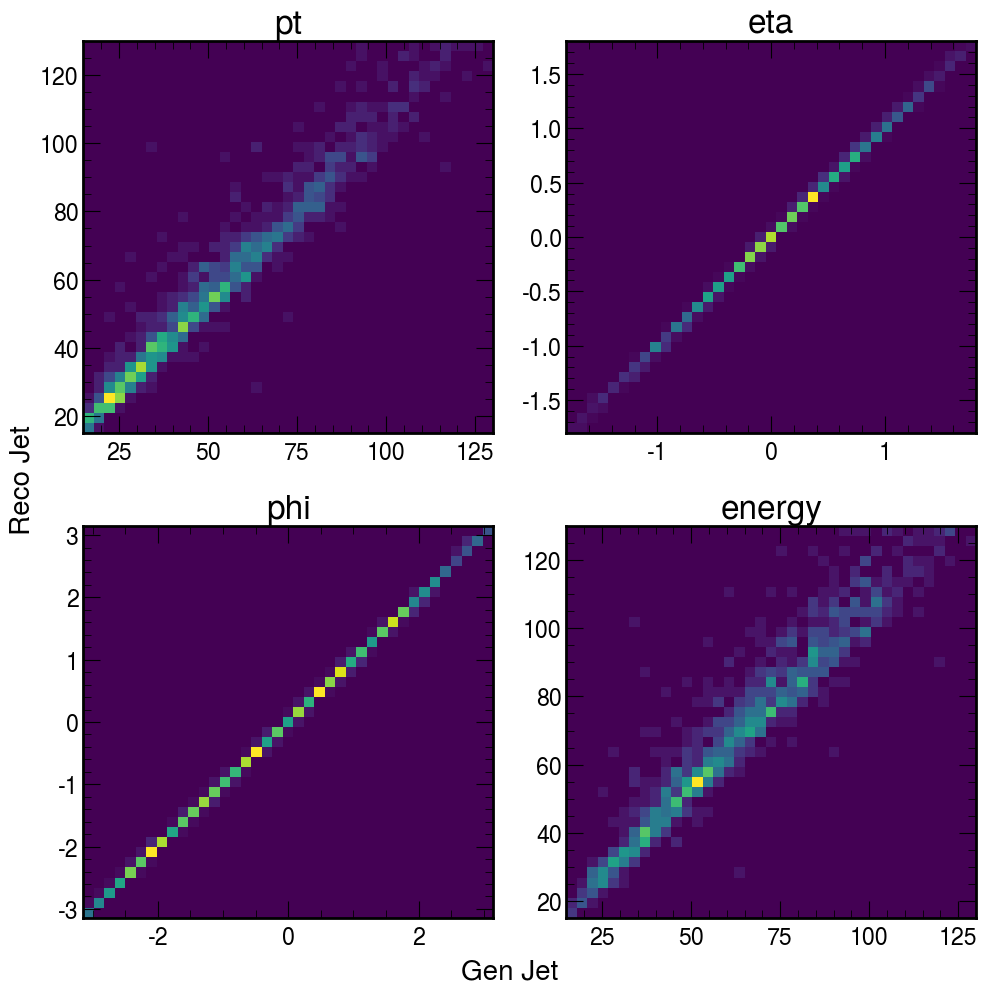

In [29]:
fig, axes = plt.subplots(figsize=(10,10), nrows=2, ncols=2)

bins = np.linspace(15,130,40)
axes[0,0].hist2d(genjets["pt"], recojets["pt"], bins) #row=0, col=0
axes[0,0].set_title("pt")

bins = np.linspace(-1.8,1.8,40)
axes[0,1].hist2d(genjets["eta"], recojets["eta"], bins) #row=1, col=0
axes[0,1].set_title("eta");

bins = np.linspace(-3.14,3.14,40)
axes[1,0].hist2d(genjets["phi"], recojets["phi"], bins) #row=1, col=0
axes[1,0].set_title("phi");

bins = np.linspace(15,130,40)
axes[1,1].hist2d(genjets["energy"], recojets["energy"], bins) #row=1, col=0
axes[1,1].set_title("energy");

fig.text(0.5, 0, 'Gen Jet', ha='center')
fig.text(0, 0.5, 'Reco Jet', va='center', rotation='vertical')

plt.tight_layout()

# Setup the downstream task

In [30]:
import torch.nn as nn
from torch_geometric.nn.pool import global_add_pool


def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        torch.nn.LayerNorm(width),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )

class JetRegressor(nn.Module):
    def __init__(
        self,
        input_dim=14,
        embedding_dim=64,
        output_dim=1,
        width=256,
        dropout=0,
    ):
        super(JetRegressor, self).__init__()

        """
        Takes as input either (1) the MLPF candidates OR (2) the latent representations of the MLPF candidates,
        and runs an MLP to predict an output per jet: "ptcorr"; which will enter the loss as follows:
            pred_jetpt = ptcorr * reco_pt

            LOSS = Huber(true_jetpt, pred_jetpt)

        """

        self.act = nn.ELU
        self.nn1 = ffn(input_dim, embedding_dim, width, self.act, dropout)
        self.nn2 = ffn(embedding_dim, output_dim, width, self.act, dropout)

    # @torch.compile
    def forward(self, X, batch):

        embeddings = self.nn1(X)
        
#         pooled_embeddings = embeddings.sum(axis=1)   # recall ~ [Batch, Particles, Features]
    
        pooled_embeddings = global_add_pool(embeddings, batch)

        return self.nn2(pooled_embeddings)

In [31]:
run_with_latentX = True

if run_with_latentX:
    input_dim = 791
else:
    input_dim = 14    
    
model = JetRegressor(input_dim).to(rank)
model.train()

JetRegressor(
  (nn1): Sequential(
    (0): Linear(in_features=791, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=256, out_features=64, bias=True)
  )
  (nn2): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [32]:
for batch in jetloader:

    batch = batch.to(rank)

    if run_with_latentX:
        X = batch["mlpfcands_latentX"]
    else:
        X = torch.cat([batch["mlpfcands_momentum"], batch["mlpfcands_pid"], batch["mlpfcands_charge"]], axis=-1)
    
    ptcorr = model(X, batch.batch).squeeze(1)
    
    target = torch.log(batch["gen_jet_pt"] / batch["reco_jet_pt"])

    loss = torch.nn.functional.huber_loss(target, ptcorr)
    
    break
print(loss)

tensor(0.0532, device='cuda:0', grad_fn=<HuberLossBackward0>)
